In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.optimize import curve_fit
from math import exp
from sklearn.metrics import r2_score
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import molecular_weight
from scipy.optimize import curve_fit

# pH of MRS medium as a function of lactic acid concentration

In [ ]:
pHs =[]
lac_cons = []
    

# pH dependent enzyme activity (logistic function)

In [2]:
def logit_func(x, k1, k2):
    return 1/(1+np.exp(-k1*(x-k2)))
def cubic_func(x, k1, k2):
    return k1*(x-k2)**3

ActpH = pd.read_csv('../data/Exp_data/pHvsEnzAct.csv')
enzymes = list( np.unique(ActpH['Enzyme']) )

In [3]:
params=[]
for enz in enzymes:
    xdata = np.array( list(ActpH[ActpH['Enzyme']==enz]['pH']) )
    ydata = np.array( list(ActpH[ActpH['Enzyme']==enz]['Activity']) )
    if enz in ['GAPD','PYK']:
        func_name = 'cubic'
        popt, pcov = curve_fit( cubic_func, xdata, ydata )
    else:
        func_name = 'logistic'
        popt, pcov = curve_fit( logit_func, xdata, ydata )
        
    params.append( {'Enzyme':enz,'func_name':func_name,'k1':round(popt[0],4),'k2':round(popt[1],4) } )
params_pd = pd.DataFrame(params)

# params_pd.to_csv('../data/GSMM_parameters/pH_EnzA.csv', index=None)

/tmp/ipykernel_2751/3418545383.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-k1*(x-k2)))


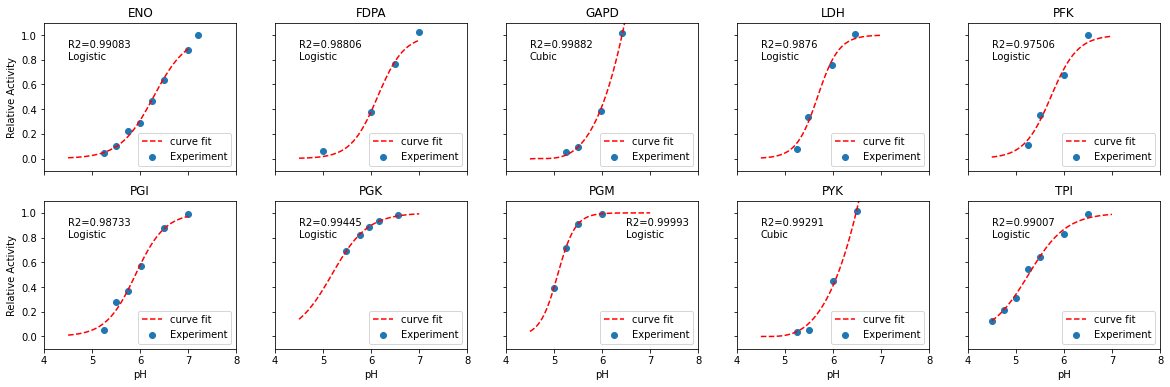

In [4]:
params_pd = pd.read_csv('../data/GSMM_parameters/pH_EnzA.csv')
fig, axs = plt.subplots(2,5,figsize=(20,6), sharex=True, sharey=True)
temp_x= np.linspace(4.5, 7.0)
for i in range(len(enzymes) ):
    x,y = int(i/5), int(i%5)
    temp_pd = ActpH[ActpH['Enzyme']==enzymes[i]]
    x_true, y_true = list(temp_pd['pH']), list(temp_pd['Activity'])
    param_data = params_pd[params_pd['Enzyme']== enzymes[i] ].values[0]
    func, k1, k2 = param_data[1], param_data[2], param_data[3]
    if func == 'logistic':
        axs[x][y].plot(temp_x, [logit_func(x, k1, k2) for x in temp_x ],'--',color='r',label='curve fit' )
        y_pred = [logit_func(x, k1, k2) for x in x_true]
    else:
        axs[x][y].plot(temp_x, [cubic_func(x, k1, k2) for x in temp_x ],'--',color='r', label='curve fit' )
        y_pred = [cubic_func(x, k1, k2) for x in x_true ]
    r2 = round( r2_score(y_pred,y_true ), 5)
    axs[x][y].scatter( x_true, y_true, label='Experiment')
    if enzymes[i] == 'PGM':
        axs[x][y].text(6.5, 0.9, 'R2='+str(r2))
    else:
        axs[x][y].text(4.5, 0.9, 'R2='+str(r2))
    if enzymes[i] in ['GAPD','PYK']:
        axs[x][y].text(4.5, 0.8, 'Cubic')
    elif enzymes[i] == 'PGM':
        axs[x][y].text(6.5, 0.8, 'Logistic')
    else:
        axs[x][y].text(4.5, 0.8, 'Logistic')
        
        
    axs[x][y].set_xlim([4,8.0])
    axs[x][y].set_ylim([-0.1,1.1])
    axs[x][y].set_title( enzymes[i] )
    axs[x][y].legend(loc='lower right')
    if x == 1:
        axs[x][y].set_xlabel('pH')
    if y== 0:
        axs[x][y].set_ylabel('Relative Activity')

# Generate inputs for kcat prediction

In [ ]:
# 'D-Xylulose 5-phosphate':,'D-Ribulose 5-phosphate':,'D-Fructose 6-phosphate':,'D-Mannose 6-phosphate':

In [3]:
GT_locus = ['1_946','1_956','1_957','1_958','1_960','1_962','1_981','1_982']
substrates = {'UDP-glucose':'C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OC3C(C(C(C(O3)CO)O)O)O)O)O',
              'UDP-galactose':'C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OC3C(C(C(C(O3)CO)O)O)O)O)O',
              'GDP-mannose':'C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)OP(=O)(O)OC4C(C(C(C(O4)CO)O)O)O)O)O)N=C(NC2=O)N'}
eps_proteins = SeqIO.parse( "../data/Genome_HMX2/protein_hmx2.fa", "fasta")
GT_seqs = {}
for seq_record in eps_proteins:
    if str(seq_record.id) in GT_locus:
        GT_seqs[str(seq_record.id)] = str(seq_record.seq).replace('*','').strip() # remove *

In [4]:
gt_ids, seqs, subs, smiles = [],[],[],[]
for sugar in substrates.keys():
    for gt_id in GT_seqs.keys():
        gt_ids.append(gt_id)
        seqs.append(GT_seqs[gt_id])
        subs.append(sugar)
        smiles.append(substrates[sugar])
Ts = [float(37.0) for i in range(len(gt_ids))]
input_pd = pd.DataFrame(zip(gt_ids,subs,seqs,smiles,Ts), \
                columns=['locus_tag','Substrate','seq','smiles','T'])

In [6]:
def scale_minmax(array, x_min, x_max):
    scaled_array = [(x-x_min)/(x_max-x_min) for x in array]
    return scaled_array

Temp_K = [ float(T+273.15) for T in list(input_pd['T']) ]
Inv_Temp =  [ 1/float(T+273.15) for T in list(input_pd['T']) ]
T_K_norm = scale_minmax( Temp_K, 273.15 , 373.15)
inv_T_norm = scale_minmax( Inv_Temp, 1/373.15 , 1/273.15)
input_pd['Temp_K_norm'] = T_K_norm
input_pd['Inv_Temp_norm'] = inv_T_norm

In [8]:
# input_pd.to_csv('../data/GSMM_parameters/DL_input.csv',index=None)

In [14]:
pred_result = pd.read_csv('../data/GSMM_parameters/DL_output.csv')
pred_result['pred_kcat'] = [10**x for x in pred_result['pred_log10kcat'] ]
kcats = list(pred_result['pred_kcat'])
enz_mws = [molecular_weight(temp_seq, "protein") for temp_seq in list(pred_result['seq']) ]
sA = [kcats[i]*3600/enz_mws[i] for i in range(len(kcats))] #unit = mmol/(mg*hr)
pred_result['Activity'] = sA

In [19]:
print( np.average( pred_result[pred_result['Substrate']=='UDP-glucose']['Activity']) )
print( np.average( pred_result[pred_result['Substrate']=='GDP-mannose']['Activity']) )
print( np.average( pred_result[pred_result['Substrate']=='UDP-galactose']['Activity']) )

1.1216623825577834
1.2996388757465578
1.1216623825577834
